# DATA PROJECT - PREMIER LEAGUE PREDICTIONS

First we import data for the 2022/23 fixtures in Premier League from the website fbref, which contains a lot of different statistics for the matches played in the season so far. Then we drop some data we don't want, and we reshape some data.

In [18]:
# Import pandas
import pandas as pd

# Import data from fbref via the url
url = 'https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures'

# Load data into a dataframe
PL_list = pd.read_html(url,index_col=False,flavor='lxml')[0]

# Append dataframe containing data to the empty list, from the url above
#PL_list.append(pd.read_html(url,index_col=False,flavor='lxml')[0])
#PL_list = pd.concat(PL_list, axis=0, ignore_index=True)

# Rename columns to differentiate expected goals for the home team and expected goals for the away team
EPL_df = PL_list[PL_list.notna()]
EPL_df = EPL_df.rename(columns={'xG':'xGHome'
                   ,'xG.1':'xGAway'})

# Extract the score so instead of having the score as eg. 0-2 we get the score to 0 for the home team and 2 for the away team
EPL_df['HomeScore'] = EPL_df['Score'].str[0]
EPL_df['AwayScore'] = EPL_df['Score'].str[2]

# Drop the columns we dont want to include 
EPL_df = EPL_df.drop(['Match Report','Notes'],axis=1)

# Convert to date
EPL_df['Date'] = pd.to_datetime(EPL_df['Date'])

# Sort matches by date 
EPL_df.sort_values(by='Date', inplace=True)

# Extract data in the wanted order
EPL_df = EPL_df[['Wk','Date','Time','Home','HomeScore','Score','xGHome','AwayScore','xGAway','Away']]

Checking the object types in our dataset

In [19]:
EPL_df.dtypes

Wk                  float64
Date         datetime64[ns]
Time                 object
Home                 object
HomeScore            object
Score                object
xGHome              float64
AwayScore            object
xGAway              float64
Away                 object
dtype: object

We then examine our data for the fixtures

In [20]:
# Create a table to examine our data for the fixtures in Premier League 2022/23
EPL_df = EPL_df.dropna()
EPL_df = EPL_df[['Date','Home','xGHome','HomeScore','Score','AwayScore','xGAway','Away']].reset_index(drop=True)
EPL_df

,Date,Home,xGHome,HomeScore,Score,AwayScore,xGAway,Away
0,2022-08-05,Crystal Palace,1.2,0,0–2,2,1.0,Arsenal
1,2022-08-06,Fulham,1.2,2,2–2,2,1.2,Liverpool
2,2022-08-06,Tottenham,1.5,4,4–1,1,0.5,Southampton
3,2022-08-06,Newcastle Utd,1.7,2,2–0,0,0.3,Nott'ham Forest
4,2022-08-06,Leeds United,0.8,2,2–1,1,1.3,Wolves
...,...,...,...,...,...,...,...,...
363,2023-05-20,Nott'ham Forest,0.6,1,1–0,0,0.6,Arsenal
364,2023-05-21,West Ham,2.1,3,3–1,1,0.9,Leeds United
365,2023-05-21,Brighton,2.5,3,3–1,1,0.6,Southampton
366,2023-05-21,Manchester City,1.2,1,1–0,0,1.2,Chelsea


We want to calculate the mean expected goals for the home team and the away team, in the league.

In [21]:
# Calculate the mean expected goals for the home team and the away team
league_Mean_Home_xG = round((EPL_df['xGHome'].mean()),2)
league_Mean_Away_xG = round((EPL_df['xGAway'].mean()),2)
print(f"The mean home expected goals is:", league_Mean_Home_xG)
print(f"The mean away expected goals is:", league_Mean_Away_xG)

The mean home expected goals is: 1.56
The mean away expected goals is: 1.25


Unsurprisingly we see that the mean expected goals for the home team is larger than for the away team.

Now we want to examine how the teams rank when looking at their expected scored goals both when playing at home and away, as well as how many goals they are expected to let in when playing at home and away. This is based on all the teams' played matches, and the numbers are unweigthed to the strength of the opponents.

In [22]:
# Create the table for expected goals
def xg_data2(df, groupby_col, xg_col, xg_per_match_col, sort_order='desc'):
    xg_per_match = df.groupby(groupby_col).agg({xg_col: 'sum', groupby_col: ['count', 'first']})
    xg_per_match.columns = [f'{xg_col}_Scored', 'TotalGames', f'{groupby_col}_Name']  
    xg_per_match[xg_per_match_col] = round((xg_per_match[f'{xg_col}_Scored'] / xg_per_match['TotalGames']), 3)
    xg_per_match = xg_per_match.reset_index()
    
    if sort_order == 'asc':
        xg_per_match.sort_values(xg_per_match_col, ascending=True, inplace=True) # When conceding it is bad to have the highest expected conceded goals, therefore ascending
    else:
        xg_per_match.sort_values(xg_per_match_col, ascending=False, inplace=True) # Descending when expected goals scored, as it is best to have the highest expected goals scores
        
    xg_per_match = xg_per_match[[groupby_col, f'{xg_col}_Scored', 'TotalGames', xg_per_match_col]]  
    
    return xg_per_match

# Table for expected goals scored, when playing at home
Scored_Home = xg_data2(EPL_df, 'Home', 'xGHome', 'Home_team_xg_per_match', sort_order='desc')[['Home', 'xGHome_Scored', 'TotalGames', 'Home_team_xg_per_match']]

# Table for expected goals scored, when playing away
Scored_Away = xg_data2(EPL_df, 'Away', 'xGAway', 'Away_team_xg_per_match', sort_order='desc')[['Away', 'xGAway_Scored', 'TotalGames', 'Away_team_xg_per_match']]

# Table for expected goals conceded, when playing at home
Conceded_Home = xg_data2(EPL_df, 'Home', 'xGAway', 'Home_xG_Conceded_per_match', sort_order='asc')[['Home', 'xGAway_Scored', 'TotalGames', 'Home_xG_Conceded_per_match']]
Conceded_Home.columns = ['Home', 'Home_xG_Conceded', 'TotalGames', 'Home_xG_Conceded_per_match']

# Table for expected goals conceded, when playing away
Conceded_Away = xg_data2(EPL_df, 'Away', 'xGHome', 'Away_team_xg_conceded_per_match', sort_order='asc')[['Away', 'xGHome_Scored', 'TotalGames', 'Away_team_xg_conceded_per_match']]
Conceded_Away.columns = ['Home', 'Away_xG_Conceded', 'TotalGames', 'Away_xG_Conceded_per_match']


*Examine the teams based on their expected goals scored at home ground*

In [23]:
Scored_Home

,Home,xGHome_Scored,TotalGames,Home_team_xg_per_match
14,Newcastle Utd,43.5,19,2.289
12,Manchester City,42.6,19,2.242
0,Arsenal,39.8,18,2.211
4,Brighton,38.6,18,2.144
11,Liverpool,40.6,19,2.137
13,Manchester Utd,32.7,17,1.924
3,Brentford,32.0,18,1.778
17,Tottenham,31.3,19,1.647
1,Aston Villa,26.5,18,1.472
18,West Ham,27.4,19,1.442


*Examine the teams based on their expected goals scored when playing away from home*

In [24]:
Scored_Away

,Away,xGAway_Scored,TotalGames,Away_team_xg_per_match
12,Manchester City,32.7,17,1.924
4,Brighton,31.1,18,1.728
11,Liverpool,27.9,18,1.550
0,Arsenal,29.1,19,1.532
10,Leicester City,29.1,19,1.532
14,Newcastle Utd,26.9,18,1.494
13,Manchester Utd,26.7,19,1.405
17,Tottenham,23.8,18,1.322
3,Brentford,23.7,19,1.247
9,Leeds United,22.1,19,1.163


*Examine the teams based on their expected goals conceded at home ground*

In [25]:
Conceded_Home

,Home,Home_xG_Conceded,TotalGames,Home_xG_Conceded_per_match
12,Manchester City,12.9,19,0.679
14,Newcastle Utd,15.8,19,0.832
13,Manchester Utd,15.6,17,0.918
0,Arsenal,18.8,18,1.044
11,Liverpool,20.3,19,1.068
17,Tottenham,20.5,19,1.079
3,Brentford,20.5,18,1.139
4,Brighton,20.6,18,1.144
5,Chelsea,21.8,18,1.211
1,Aston Villa,22.4,18,1.244


*Examine the teams based on their expected goals conceded away from home*

In [26]:
Conceded_Away

,Home,Away_xG_Conceded,TotalGames,Away_xG_Conceded_per_match
12,Manchester City,15.8,17,0.929
0,Arsenal,22.9,19,1.205
14,Newcastle Utd,21.9,18,1.217
6,Crystal Palace,24.9,19,1.311
5,Chelsea,23.8,18,1.322
4,Brighton,24.7,18,1.372
3,Brentford,28.2,19,1.484
18,West Ham,27.1,18,1.506
1,Aston Villa,28.7,19,1.511
17,Tottenham,27.5,18,1.528


# Now we focuse on the match played sunday 09/04/23 between Liverpool - Arsenal, to try and see if we by the data above can predict the correct result in the match

In [27]:

# Set date so we only use data from matches played before this specific match
date_threshold = pd.to_datetime('2023-04-8')

# Filter the DataFrame to include matches played before the date threshold
LivArs = EPL_df[EPL_df['Date'] < date_threshold]

# Calculate the average expected goals scored for Liverpool when playing at home
liverpool_home_avg_xg = LivArs[LivArs['Home'] == 'Liverpool']['xGHome'].mean()

# Calculate the average expected goals conceded by Arsenal when playing away
arsenal_away_avg_xg_conceded = LivArs[LivArs['Away'] == 'Arsenal']['xGHome'].mean()

# Calculate the average expected goals conceded for Liverpool when playing at home
liverpool_home_avg_xg_conceded = LivArs[LivArs['Home'] == 'Liverpool']['xGAway'].mean()

# Calculate the average expected goals scored by Arsenal when playing away
arsenal_away_avg_xg= LivArs[LivArs['Away'] == 'Arsenal']['xGAway'].mean()

# Print the average expected goals
print(f"Average expected goals scored by Liverpool when playing at home: {liverpool_home_avg_xg:.3f}")
print(f"Average expected goals conceded by Arsenal when playing away: {arsenal_away_avg_xg_conceded:.3f}")
print(f"Average expected goals conceded by Liverpool when playing at home: {liverpool_home_avg_xg_conceded:.3f}")
print(f"Average expected goals scored by Arsenal when playing away: {arsenal_away_avg_xg:.3f}")


Average expected goals scored by Liverpool when playing at home: 2.077
Average expected goals conceded by Arsenal when playing away: 0.914
Average expected goals conceded by Liverpool when playing at home: 1.046
Average expected goals scored by Arsenal when playing away: 1.614


In [28]:
# Calculate the expected goals scored by Liverpool based on expected goals scored by Liverpool at home multiplied by expected goals conceded by Arsenal away

Liverpool_home_expected_xg = liverpool_home_avg_xg * arsenal_away_avg_xg_conceded 

print(f"Liverpool expected goals against Arsenal when playing at home: {Liverpool_home_expected_xg:.3f}")

Liverpool expected goals against Arsenal when playing at home: 1.899


In [29]:
# Calculate the expected goals scored by Arsenal based on expected goals scored by Arsenal away multiplied by expected goals conceded by Liverpool at home

Arsenal_away_expected_xg = arsenal_away_avg_xg * liverpool_home_avg_xg_conceded

print(f"Arsenal expected goals against Liverpool when playing away from home: {Arsenal_away_expected_xg:.3f}")

Arsenal expected goals against Liverpool when playing away from home: 1.689


From this simple calculations we would expect the match result to be approximately 2-2, although this is a very simple way of trying to predict the result. 
For that reason, we try to predict the outcome of the match by predicting the number of goals. For this matter we assume the number of goals follows a poisson distribution. We use the poisson.pmf to calculate the probability mass function in a poisson distribution, because we can then calculate the probability of a specific outcome in terms of number of goals. By using the poisson distribution, it is implicitly assumed that goals is scored randomly and are independent of each other. In this way the poisson distributions estimates the probabilities of a given outcome, when the home and away team are restricted to score a maximum of six goals, as the probability of scoring more than six goals in a match like this is very small.  

It is important to note that some of the assumptions from using the poisson distribution can be problematic for this purpose. As stated above by using the poisson distribution, we assume that goals are independent of each other. In reality, if a team scores two goals in five minutes, this can create momentum for the scoring team, or in reverse make the opponent unmotivated, and hence the probability of scoring another goal increases. This explanation also speaks against the assumption that the rate of goals is constant throught the match, due to e.g.momentum. We still use this approach as we find it the most intuitive.

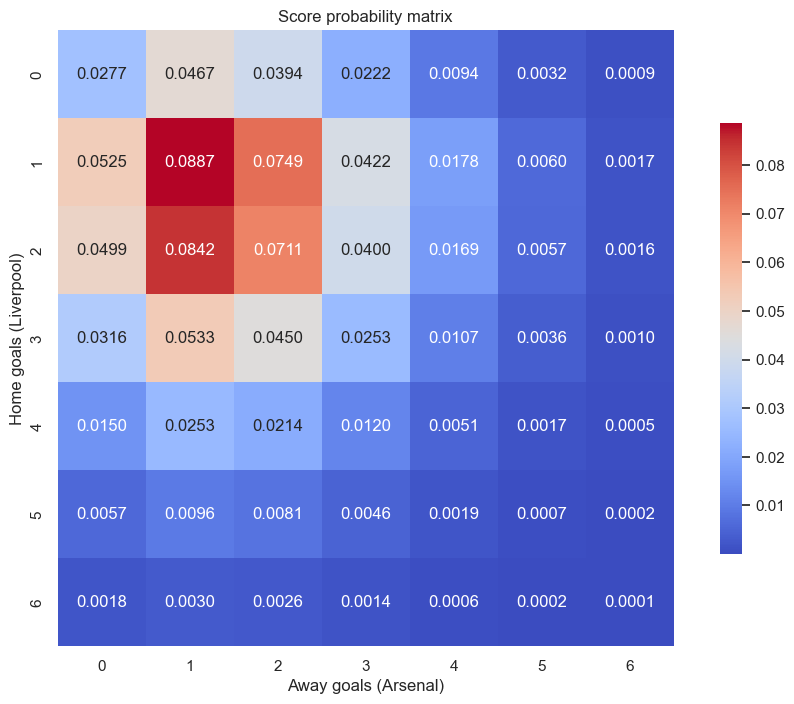

In [30]:
# Import packages 
import numpy as np
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt

# We set the maximum amount of goals a team can score in the match. This is based on what gives the most intuitive result in the matrix below
max_score = 6
score_range = np.arange(0, max_score+1)

# Use the Poisson distribution to get the probability of each possible score in the match
home_pmf = poisson.pmf(score_range, Liverpool_home_expected_xg)
away_pmf = poisson.pmf(score_range, Arsenal_away_expected_xg)

# Calculate the outer product of the home and away PMFs
score_prob_matrix = np.outer(home_pmf, away_pmf)

# Reshape the matrix into a square matrix of score probabilities
score_prob_matrix = score_prob_matrix.reshape(max_score+1, max_score+1)

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Create a heatmap with probabilities
sns.set()
sns.heatmap(score_prob_matrix, cmap="coolwarm", annot=True, fmt=".4f", square=True, cbar_kws={"shrink": 0.7}, ax=ax)

# Set the axis labels and title
plt.xlabel("Away goals (Arsenal)")
plt.ylabel("Home goals (Liverpool)")
plt.title("Score probability matrix")

# Display the plot
plt.show()

We want to sum up the probabilities of the three outcomes in a match: Home win, draw, Away win

In [31]:
import tabulate

# Calculate the sum of home wins, draws, and away wins from the matrix above
home_wins = np.sum(np.tril(score_prob_matrix, -1))
draws = np.sum(np.diag(score_prob_matrix))
away_wins = np.sum(np.triu(score_prob_matrix, 1))

# Create a table showing the probabilities of outcomes
table_data = [
    ["Home wins", "{:.2%}".format(home_wins)],
    ["Draws", "{:.2%}".format(draws)],
    ["Away wins", "{:.2%}".format(away_wins)]
]
headers = ["Outcome", "Probability"]
table = tabulate.tabulate(table_data, headers=headers, tablefmt="pretty")

# Display the table
print(table)

# Checking if the probabilities approximately sum to 1 (100%)
total_prob = home_wins + draws + away_wins
print(f"The sum of probabilities is: {total_prob:.2%}")


+-----------+-------------+
|  Outcome  | Probability |
+-----------+-------------+
| Home wins |   42.98%    |
|   Draws   |   21.86%    |
| Away wins |   34.63%    |
+-----------+-------------+
The sum of probabilities is: 99.48%


The sum of probabilities doesn't sum to 100% as we have set the maximum amount of goals to 6, setting the maximum amount of goals per team higher, will increase the sum of probabilities, but will make the figure less intuitive to intrepret.

# Compares out model with odds before the match

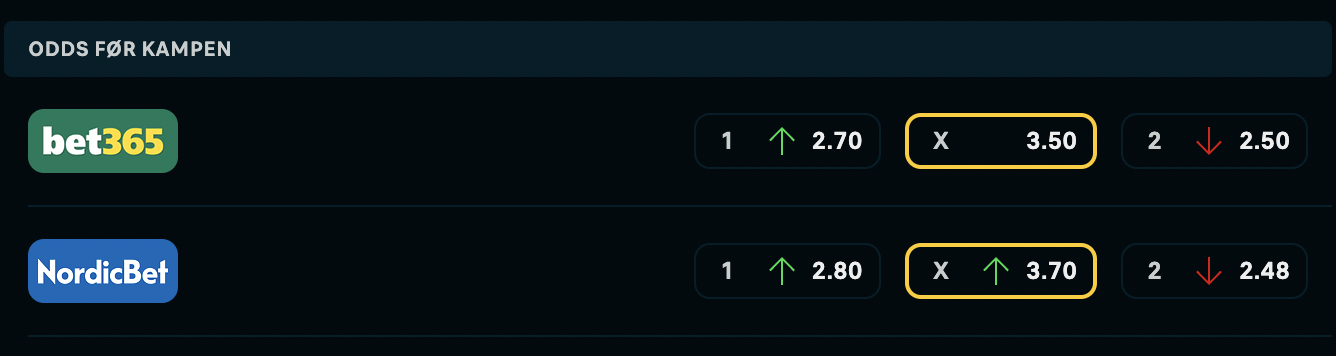

# This equals the following probabilities for a given outcome (Based on the odds from Bet365)

Odds 2.7 = 37,04%

Odds 3.5 = 28,57%

Odds 2.5 = 40,00%



In [32]:

import tabulate

# Create a table showing the probabilities based on the odds
odds_data = [
    ["2.7", "37,04%"],
    ["3.5", "28,57%"],
    ["2.5", "40,00%"]
]
headers = ["Odds", "Probability"]
odds_table = tabulate.tabulate(odds_data, headers=headers, tablefmt="pretty")

# Display the table
print(odds_table)

+------+-------------+
| Odds | Probability |
+------+-------------+
| 2.7  |   37,04%    |
| 3.5  |   28,57%    |
| 2.5  |   40,00%    |
+------+-------------+


# Compares the probabilities from our model to the probabilities based on the odds from Bet365

In [33]:
# Compare our model with the odds
# Create a table showing the probabilities of outcomes
table_data = [
    ["Home win", "{:.2%}".format(home_wins), "37,04%"],
    ["Draw", "{:.2%}".format(draws), "28,57%"],
    ["Away win", "{:.2%}".format(away_wins), "40,00%"]
]
headers = ["Outcome", "Our model", "Odds"]
table = tabulate.tabulate(table_data, headers=headers, tablefmt="pretty")

# Display the table
print(table)

+----------+-----------+--------+
| Outcome  | Our model |  Odds  |
+----------+-----------+--------+
| Home win |  42.98%   | 37,04% |
|   Draw   |  21.86%   | 28,57% |
| Away win |  34.63%   | 40,00% |
+----------+-----------+--------+


The table above shows that our model predicts a higher probability of Liverpool winning the match, compared to the odds from Bet365. This shows that our model has some flaws. Our model is very simple and only takes expected goals for and against as inputs, and doesn't include a lot of different important factors as current form, injuries to key players, local derbies etc. The odds is also based on what the customers believe about the match, and can therefore be adjusted to the odds at initial offering, which reflects the probabilities from Bet365's model. 

# Predicting the result of Manchester City - Leicester before the match is played 

To avoid writing all the code above to create the probability matrix for a given match, we now try to create a function takes inputs as a dataframe, a home team and an away team. In the example below we have adapted our code to the match between Manchester City and Leicester City played on the 15th of April, and hence we restrict our match data to the 14th of April. The Code also produces a table with percentage probability of each outcome: Home win, draw and away wins.

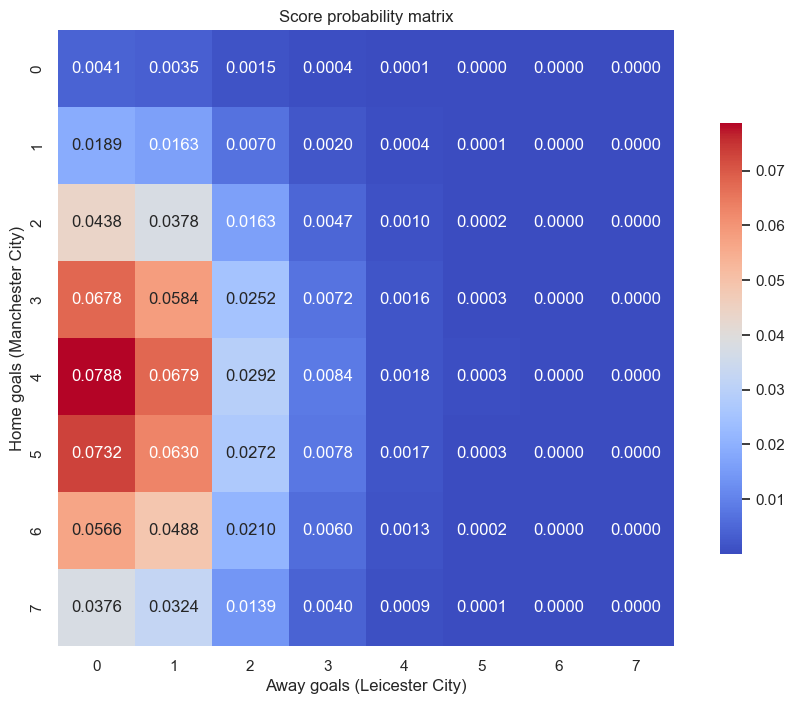

+----------+-------------+
| Outcome  | Probability |
+----------+-------------+
| Home win |   83.19%    |
|   Draw   |    4.60%    |
| Away win |    2.33%    |
+----------+-------------+
The sum of probabilities is: 99.48%


In [34]:
# Set a date to restrict the matches upon
Restrict_Date = pd.to_datetime('2023-04-14') # We set the date needed for the match between Man City and Leicester

# Filter a DataFrame --> Could be excluded, but needed for this specific match
EPL2_df = EPL_df[EPL_df['Date'] < Restrict_Date]

def compute_score_probability_matrix(EPL2_df, home_team, away_team):
    # Filter the DataFrame for the specified home and away teams
    home_df = EPL2_df[EPL2_df['Home'] == home_team]
    away_df = EPL2_df[EPL2_df['Away'] == away_team]
    
    # Calculate the average expected scored and conceded goals for the home and away teams
    home_avg_xg = home_df['xGHome'].mean()
    away_avg_xg = away_df['xGAway'].mean()
    concede_h_avg_xg = home_df['xGAway'].mean()
    concede_a_avg_xg = away_df['xGHome'].mean()

    # The expected scoring of the home team given how many goals the away team concedes, and vice versa for the away team
    home_score = home_avg_xg * concede_a_avg_xg
    away_score = away_avg_xg * concede_h_avg_xg
    
    # Set the maximum number of goals a team can score in the match
    max_score = 7
    score_range = np.arange(0, max_score + 1)
    
    # Use the Poisson distribution to get the probability of each possible score in the match
    home_pmf2 = poisson.pmf(score_range, home_score)
    away_pmf2 = poisson.pmf(score_range, away_score)
    
    # Calculate the outer product of the home and away PMFs
    score_prob_matrix2 = np.outer(home_pmf2, away_pmf2)
    
    # Reshape the matrix into a square matrix of score probabilities
    score_prob_matrix2 = score_prob_matrix2.reshape(max_score + 1, max_score + 1)
    
    # Set the figure size
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create a heatmap with probabilities
    sns.set()
    sns.heatmap(score_prob_matrix2, cmap="coolwarm", annot=True, fmt=".4f", square=True, cbar_kws={"shrink": 0.7}, ax=ax)
    
    # Set the axis labels and title
    plt.xlabel(f"Away goals ({away_team})")
    plt.ylabel(f"Home goals ({home_team})")
    plt.title("Score probability matrix")
    
    # Display the plot
    plt.show()

    # Calculate the sums of home wins, draws, and away wins from the matrix
    home_wins2 = np.sum(np.tril(score_prob_matrix2, -1))
    draws2 = np.sum(np.diag(score_prob_matrix2))
    away_wins2 = np.sum(np.triu(score_prob_matrix2, 1))

    # Create a table showing the probabilities of outcomes
    table_data = [
    ["Home win", "{:.2%}".format(home_wins2)],
    ["Draw", "{:.2%}".format(draws2)],
    ["Away win", "{:.2%}".format(away_wins2)]
    ]
    headers2 = ["Outcome", "Probability"]
    table2 = tabulate.tabulate(table_data, headers=headers2, tablefmt="pretty")

    # Display the table
    print(table2)

    # Checking if the probabilities approximately sum to 1 (100%)
    total_prob2 = home_wins + draws + away_wins
    print(f"The sum of probabilities is: {total_prob2:.2%}")

# Use our example of the match between Manchester City and Leicester City
compute_score_probability_matrix(EPL2_df, 'Manchester City', 'Leicester City')

The sum of probabilities doesn't sum to 100% as we have set the maximum amount of goals to 7, setting the maximum amount of goals per team higher, will increase the sum of probabilities, but will make the figure less intuitive to intrepret.

The match ended 3-1, and therefore the model predicted the result somewhere near the actual result. But it probably wouldn't need a statistical model to predict that Manchester City would win the match.

# Conclusion

We have used the poisson distribution to try and predict the outcome of Premier League matches, based on statistics of expected goals scored and conceded. Comparing our predictions with the actual outcome, we see that our model predicts somewhere near the actual outcome, but still lacks a lot of information to be more precise in the predictions. To obtain more accurate predictions, we would need to include other important parameters as injuries, current form, momentum, how many games they have played up till this match to measure some tiredness and other parameters.  

An idea for an extension could be to use logistic regression to predict the probability of a given outcome, based on the expected goals for each team. It is then important that the predictions is based upon the games earlier played from both of the teams playing in this given match. We tried to do something like this, but as we didn't succeed in reaching a sufficient outcome, we chose not to include it in this project.